In [11]:
# Step 1: Install Dependencies (if needed in Colab)
!pip install xgboost scikit-learn matplotlib pandas numpy --quiet


In [12]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb

In [13]:
# Step 3: Load Dataset
# (In Colab, upload file from local system)
from google.colab import files
uploaded = files.upload()

# Replace with your uploaded file name
df = pd.read_csv("diabetic_data.csv")


Saving diabetic_data.csv to diabetic_data (1).csv


In [14]:
# Step 4: Data Preprocessing
# Drop identifier columns
df = df.drop(["encounter_id", "patient_nbr"], axis=1)

# Encode target variable (readmitted)
# Convert: NO = 0, <30 = 1, >30 = 1
df["readmitted_binary"] = df["readmitted"].apply(lambda x: 0 if x == "NO" else 1)

# Replace "?" with NaN
df = df.replace("?", np.nan)

# Drop columns with too many missing values
df = df.drop(["weight", "payer_code", "medical_specialty"], axis=1)

# Encode categorical variables
categorical_cols = df.select_dtypes(include=["object"]).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])

# Features & target
X = df.drop(["readmitted", "readmitted_binary"], axis=1)
y = df["readmitted_binary"]

In [15]:
# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
# Step 6: Build XGBoost Model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    base_score=0.5,
    eval_metric="auc",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train model
model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [17]:
# Step 7: Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


In [18]:
# Step 8: Evaluation
print("📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n🔥 ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70     10973
           1       0.64      0.56      0.60      9381

    accuracy                           0.65     20354
   macro avg       0.65      0.65      0.65     20354
weighted avg       0.65      0.65      0.65     20354


✅ Confusion Matrix:
 [[8071 2902]
 [4137 5244]]

🔥 ROC-AUC Score: 0.7097580067666744


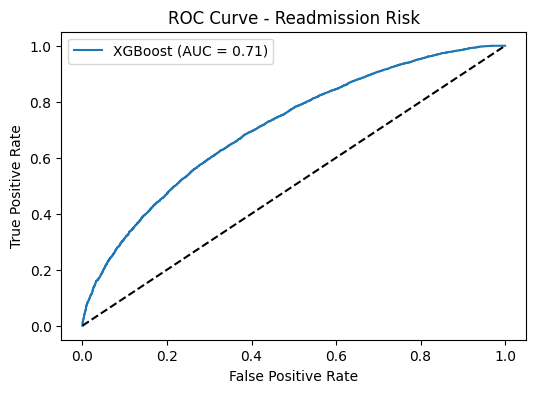

In [19]:
# Step 9: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="XGBoost (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Readmission Risk")
plt.legend()
plt.show()